# Parsing APRS/AX.25 packets from audio from scratch

References:

* https://web.stanford.edu/class/ee179/labs/Lab7.html
* https://www.tapr.org/pdf/AX25.2.2.pdf
* http://www.aprs.org/doc/APRS101.PDF
* https://github.com/echicken/node-ax25/blob/es6rewrite/packet.js

## TNC test CD

We'll use WA8LMF's test CD. It contains audio samples of APRS packets.

1. Download the TNC test CD from [here](http://wa8lmf.net/TNCtest/getfile.htm)
1. Extract the ZIP, you should get a `.cue` and `.bin` file
1. Use `bchunk` to convert those to `.wav` files: `bchunk -w TNC_Test_Ver-1.1.bin TNC_Test_Ver-1.1.cue image`
1. You should end up with something like this:

```bash
$ bchunk -w TNC_Test_Ver-1.1.bin TNC_Test_Ver-1.1.cue image
...

$ ls
image01.wav  image02.wav  image03.wav  image04.wav  image05.wav  image06.wav  image07.wav  image08.iso  _READme.htm  TNC_Test_Ver-1.1.bin  TNC_Test_Ver-1.1.cue

```

`.wav` properties:

```bash
$ file image01.wav
image01.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 16 bit, stereo 44100 Hz
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, resample, spectrogram, butter, lfilter, firwin, filtfilt, welch
from scipy.io import wavfile
from math import pi
from itertools import takewhile
from pathlib import Path
from scipy.fft import fft, fftfreq, fftshift
import wave
from math import floor
from statistics import median, stdev, mean, variance

In [132]:
MAX_PACKET_LENGTH = 332 * 8

In [2]:
# Utility functions

def byte_to_char(b):
    """Return the character represented by the byte b (as a list of 1's and 0's) with LSB first"""
    if len(b) < 8:
        return '?'

    bv = b[0]*1 + b[1]*2 + b[2]*4 + b[3]*8 + b[4]*16 + b[5]*32 + b[6]*64 + b[7]*128
    return chr(bv)

def char_to_byte(c):
    """Convert the character c to a byte (as a list of 1's and 0's) with LSB first"""
    return [ int(x) for x in f'{ord(c):b}'.zfill(8)[::-1] ]


def chunk(l, n):
    """Chunk a list l into chunks (lists) of length n"""
    n = max(1, n)
    return list(l[i:i+n] for i in range(0, len(l), n))

def bit_stuff(arr):
    """Perform bit stuffing on arr: add a zero after five ones in a row"""
    arr = list(arr)
    i = 0
    while i < len(arr):
        if i >= 4 and arr[i-4] == 1 and arr[i-3] == 1 and arr[i-2] == 1 and arr[i-1] == 1 and arr[i] == 1:
            # We have 5 ones in a row => time to stuff
            arr.insert(i+1, 0)

        i = i + 1

    return np.array(arr)

def bit_destuff(arr):
    """Perform bit de-stuffing on arr: remove a stuffed zero after five ones in a row"""
    arr = list(arr)
    i = 0
    while i < len(arr):
        if i >= 4 and arr[i-5] == 1 and arr[i-4] == 1 and arr[i-3] == 1 and arr[i-2] == 1 and arr[i-1] == 1:
            if (arr[i] != 0):
                print(f'Warning: I had 5 ones in a row during bit de-stuffing, and expected a 0 but got {arr[i]} at index {i}')
            
            # We have 5 ones in a row => time to remove stuffed zero
            print(f'Bit de-stuff: removing {arr[i]} at position {i}')
            arr.pop(i)
            i = i + 1

        i = i + 1

    return np.array(arr)

def nrzi_decode(arr):
    """Perform non-return to zero inverted decoding"""
    return [ 1 if x == y else 0 for x, y in zip([0] + arr, arr[1:] + [0])]


In [3]:
tnc_test_file_location = '/home/thomas/tmp/tnc_test_cd/image01.wav'
tnc_test_file_sample_rate, tnc_test_file = wavfile.read(tnc_test_file_location)

print(f'Sample rate: {tnc_test_file_sample_rate}Hz, channels: {tnc_test_file.shape[1]}, samples: {tnc_test_file.shape[0]}, length: {tnc_test_file.shape[0]/tnc_test_file_sample_rate}s')

Sample rate: 44100Hz, channels: 2, samples: 68236812, length: 1547.32s


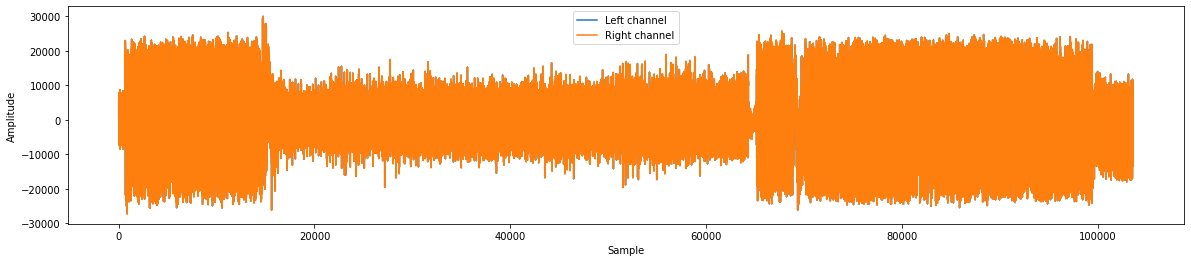

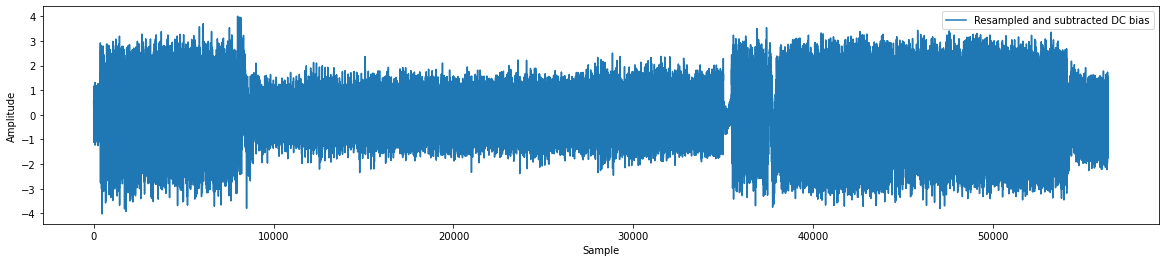

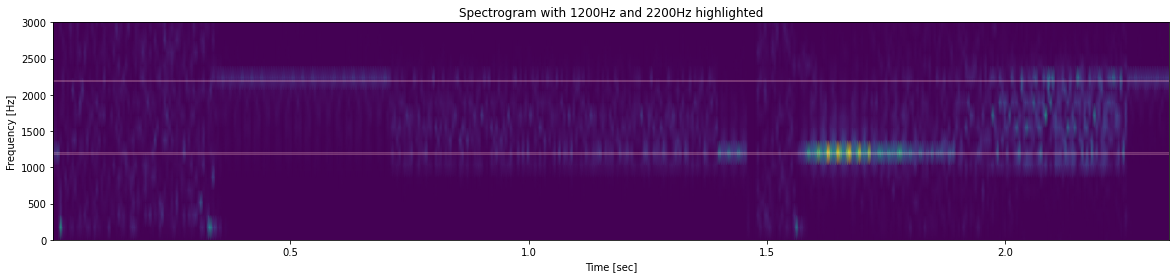

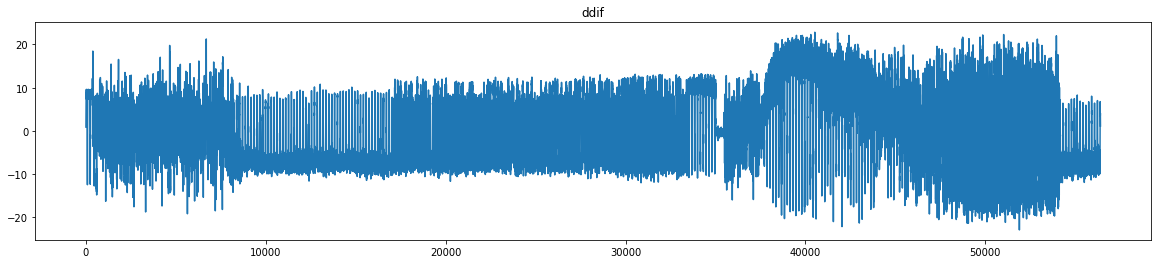

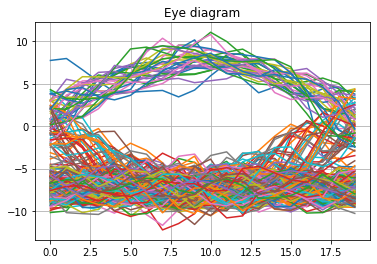

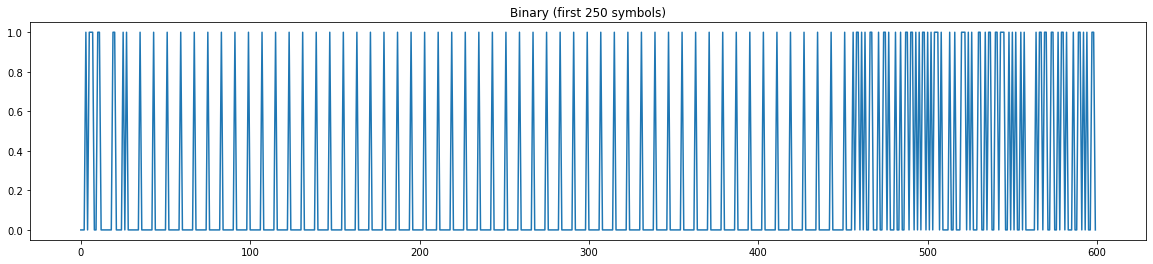

In [4]:
tnc_packet = tnc_test_file[int(44100*9.65):44100*12]

fig, ax = plt.subplots()
ax.plot(tnc_packet[:, 0], label='Left channel')
ax.plot(tnc_packet[:, 1], label='Right channel')
ax.legend()
fig.set_figwidth(20)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


tnc_packet = tnc_packet[:, 0] # Use left channel

dc_bias = sum(tnc_packet)/len(tnc_packet)
tnc_packet = tnc_packet - dc_bias

tnc_packet = resample(tnc_packet, int((24000/44100) * len(tnc_packet)))


# Rescale amplitude - not needed?
tnc_packet = tnc_packet * (4/np.max(tnc_packet))

fig, ax = plt.subplots()
ax.plot(tnc_packet, label='Resampled and subtracted DC bias')
ax.legend()
fig.set_figwidth(20)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Calculate spectrogram for a portion of the file
x = tnc_test_file[int(44100*9.65):44100*12][:,0]
fs = 44100
f, t, Sxx = spectrogram(x, fs)

fig, ax = plt.subplots()
ax.pcolormesh(t, f, Sxx, shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.axhspan(1200-10, 1200+10, alpha=0.2, color='pink')
ax.axhspan(2200-10, 2200+10, alpha=0.2, color='pink')
fig.set_figwidth(20)
ax.set_ylim([0,3000])
ax.set_title('Spectrogram with 1200Hz and 2200Hz highlighted')

# Convolve with 1200Hz and 2200Hz over the packet
dpf = tnc_packet

t20 = np.array([ x/20 for x in range(-10,10) ]).astype(np.longdouble)
mf1200 = np.exp(1j*2*pi*t20*1.0)
mf2200 = np.exp(1j*2*pi*t20*1.8)

d12 = np.convolve(dpf, mf1200,'same')
d22 = np.convolve(dpf, mf2200,'same')
ddif = abs(d12)-abs(d22)

# Plot amplitude
fig, ax = plt.subplots()
# ax.plot(ddif[0:20000])
ax.plot(ddif)
fig.set_figwidth(20)
ax.set(title='ddif')
plt.show()


offset = 4

n1 = 8500 + offset
n2 = n1 + 20*256

# Choose n2 to be an integer number of samples into the packet (here 256). We can then make an eye diagram with:
boff = [ x for x in range(-10, 10) ]
eyed = np.reshape(ddif[n1-10:n2-10], (20,256), 'F')

fig, ax = plt.subplots()
ax.plot(eyed)
ax.set(title='Eye diagram')
ax.grid()
plt.show()


bts = ddif[offset::20] > 0

fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(bts[400:1000])
ax.set(title='Binary (first 250 symbols)')
plt.show()

/home/personal/.cache/pypoetry/virtualenvs/python-ax25-experiment-mMXFg9Xu-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


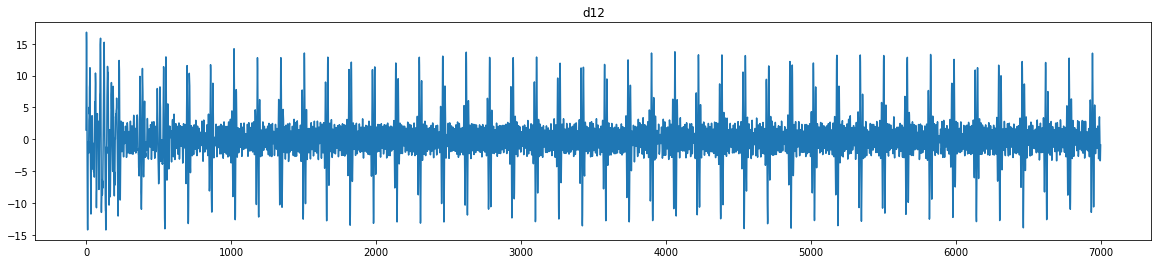

/home/personal/.cache/pypoetry/virtualenvs/python-ax25-experiment-mMXFg9Xu-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


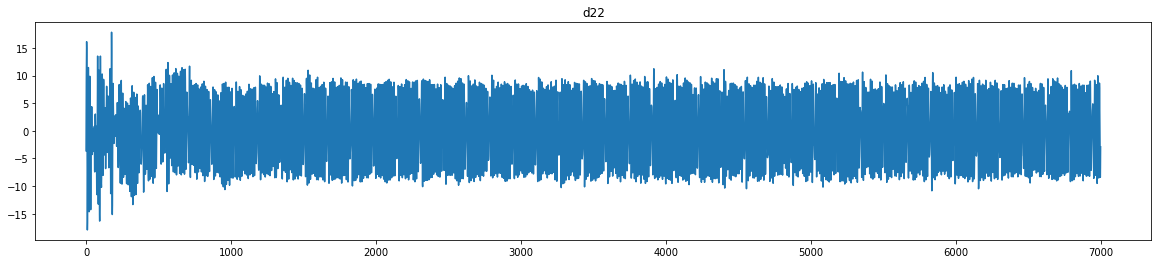

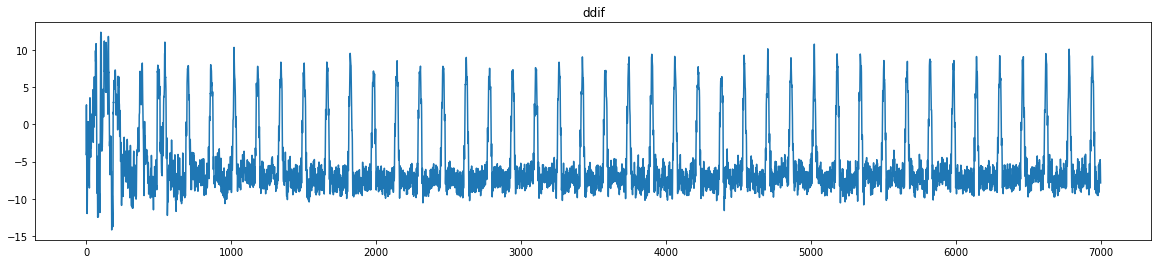

In [5]:
# Plot amplitude
fig, ax = plt.subplots()
# ax.plot(ddif[0:20000])
ax.plot(d12[8000:15000])
fig.set_figwidth(20)
ax.set(title='d12')
plt.show()
# Plot amplitude
fig, ax = plt.subplots()
# ax.plot(ddif[0:20000])
ax.plot(d22[8000:15000])
fig.set_figwidth(20)
ax.set(title='d22')
plt.show()
# Plot amplitude
fig, ax = plt.subplots()
# ax.plot(ddif[0:20000])
ax.plot(ddif[8000:15000])
fig.set_figwidth(20)
ax.set(title='ddif')
plt.show()

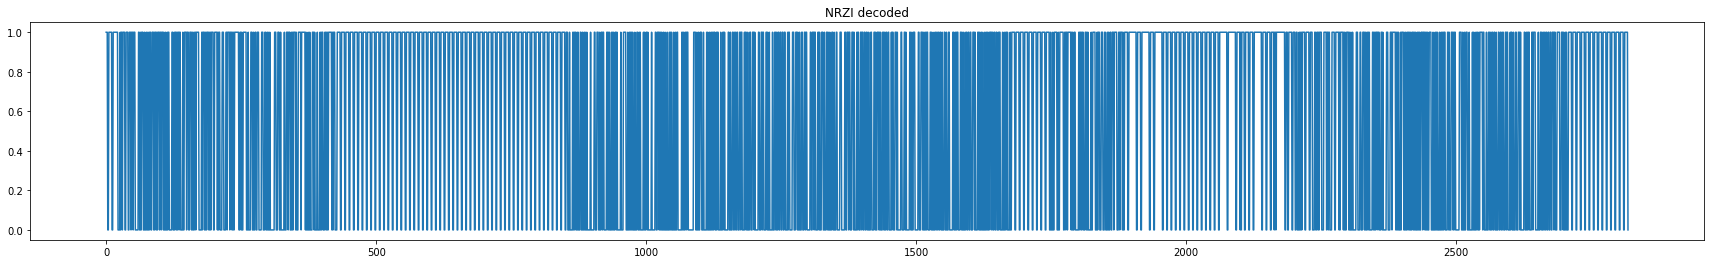

In [6]:
db = nrzi_decode(bts)

fig, ax = plt.subplots()
fig.set_figwidth(30)
ax.plot(db)
ax.set(title='NRZI decoded')
plt.show() 

Frames start at [4, 253, 411, 427, 435, 443, 451, 459, 467, 475, 483, 491, 499, 507, 515, 523, 531, 539, 547, 555, 563, 571, 579, 587, 595, 603, 611, 619, 627, 635, 643, 651, 659, 667, 675, 683, 691, 699, 707, 715, 723, 731, 739, 747, 755, 763, 771, 779, 787, 795, 803, 811, 819, 827, 835, 843, 1676, 1684, 1692, 1700, 1708, 1716, 1724, 1732, 1740, 1780, 1885, 1909, 1933, 1957, 1965, 1973, 1981, 1989, 1997, 2005, 2013, 2021, 2029, 2037, 2045, 2053, 2093, 2109, 2117, 2141, 2149, 2189, 2221, 2276, 2381, 2707, 2715, 2723, 2731, 2739, 2747, 2755, 2763, 2771, 2779, 2787, 2795, 2803, 2811]
Frames end at   [12, 261, 419, 435, 443, 451, 459, 467, 475, 483, 491, 499, 507, 515, 523, 531, 539, 547, 555, 563, 571, 579, 587, 595, 603, 611, 619, 627, 635, 643, 651, 659, 667, 675, 683, 691, 699, 707, 715, 723, 731, 739, 747, 755, 763, 771, 779, 787, 795, 803, 811, 819, 827, 835, 843, 851, 1684, 1692, 1700, 1708, 1716, 1724, 1732, 1740, 1748, 1788, 1893, 1917, 1941, 1965, 1973, 1981, 1989, 1997, 2005, 2

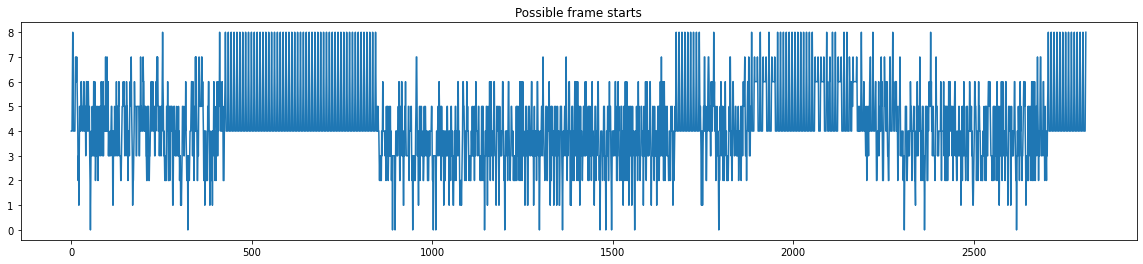

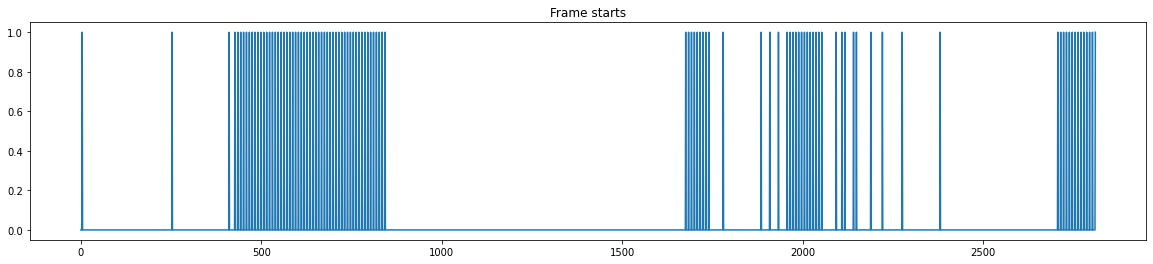

In [7]:
frame_starts = [ sum([not(s0), s1, s2, s3, s4, s5, s6, not(s7)]) for s0,s1,s2,s3,s4,s5,s6,s7 in zip(db, db[1:], db[2:], db[3:], db[4:], db[5:], db[6:], db[7:])]

frame_start_indices = [ idx for idx, x in enumerate(frame_starts) if x == 8 ]

print(f'Frames start at {frame_start_indices}')

print(f'Frames end at   {list(map(lambda x: x + 8, frame_start_indices))}')

fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(frame_starts)
ax.set(title='Possible frame starts')
fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(list(map(lambda x: x == 8, frame_starts)))
ax.set(title='Frame starts')
plt.show() 

In [8]:
packet_start = 851
packet_end = 1676

packet = np.array(db[packet_start:packet_end]).astype(int)
print(f'Length before destuffing: {len(packet)}')
packet = bit_destuff(packet)
print(f'Length after destuffing: {len(packet)}')

Length before destuffing: 825
Bit de-stuff: removing 0 at position 112
Length after destuffing: 824


In [73]:
def shift_byte(byte):
    return list(byte)[1:] + [0]

def parse_address(b):
    # Format: 0SSIDRRC
    # See https://www.tapr.org/pdf/AX25.2.2.pdf, page 12
    last_address_byte = b[6]

    return {
        "callsign": ''.join(map(lambda byte: byte_to_char(shift_byte(byte)), b[0:6])).rstrip(),
        "ssid": last_address_byte[1] + last_address_byte[2] * 2 + last_address_byte[3] * 4 + last_address_byte[4] * 8,
        "reserved_bits": last_address_byte[5:7],
        "command_response": True if last_address_byte[7] else False
    }

parse_address(chunk(packet,8)[7:14])

{'callsign': 'PI1ETL',
 'ssid': 0,
 'reserved_bits': array([1, 1]),
 'command_response': False}

In [74]:
def parse_packet(pack):
    # Digipeater addresses are 7 characters long
    # A '1' in the left-most position of the byte (LBS) signifies the digipeater list is over
    number_of_digipeaters_addresses = len(list((takewhile(lambda offset: chunk(packet, 8)[14::7][offset][0] == 0, range(0,9)))))
    
    return {
        "destination": parse_address(pack[0:7]),
        "source": parse_address(pack[7:14]),
        "digipeaters": list(map(lambda digipeater_offset: parse_address(pack[14+digipeater_offset*7:14+digipeater_offset*7+7]), range(0, number_of_digipeaters_addresses))),
        "control_field": pack[14+number_of_digipeaters_addresses*7],
        "protocol_id": pack[15+number_of_digipeaters_addresses*7],
        "information": ''.join(list(map(lambda b: byte_to_char(b), pack[16+number_of_digipeaters_addresses*7:]))[:-2]),
        "frame_check_sequence": pack[-2:]
    }

parse_packet(chunk(packet, 8))


# Expected:
#  N6XQY-12>GPSLJ,RELAY,WIDE2-2:$GPRMC,013641.06,A,3348.1607,N,11807.4631,W,34.0,090.5,231105,13.,E*73<0x0d>

{'destination': {'callsign': 'APMI06',
  'ssid': 0,
  'reserved_bits': array([1, 1]),
  'command_response': False},
 'source': {'callsign': 'PI1ETL',
  'ssid': 0,
  'reserved_bits': array([1, 1]),
  'command_response': False},
 'digipeaters': [{'callsign': 'ON0ANT',
   'ssid': 10,
   'reserved_bits': array([1, 1]),
   'command_response': True},
  {'callsign': 'ON0TVO',
   'ssid': 0,
   'reserved_bits': array([1, 1]),
   'command_response': True},
  {'callsign': 'WIDE2',
   'ssid': 0,
   'reserved_bits': array([1, 1]),
   'command_response': True}],
 'control_field': array([1, 1, 0, 0, 0, 0, 0, 0]),
 'protocol_id': array([0, 0, 0, 0, 1, 1, 1, 1]),
 'information': '}PI1ETL-13>APRS,TCPIP,PI1ETL*:@021748z5134.53N/00438.69E_038/005g008t046r...p000P000b10280h58.weewx-4.4.0-WMR200^\x90¾.\x8dk\x86M\x7fþ\x01\x83\x8fÜx\x95\x9e¹Ù\x0f\x1e\xa0î¤ô/ÿfe\x0eá¿Dg\x12\x18þDÈüp^Ï9\x7fË9ßú\x9f¦^\x8f\x98\'?}\x95Ô\x05R\x94x\x8e\x8bfË¹,É\x95wýäËu8Ï\x81ú}ø{Tb%-ßgþ!\x18\x00\xad\x01\x06\x10ÌL\x04h\x16\x8d§}\x82«

## Finding packets in a file

In [146]:
def load_asset(name):
    base_path = Path(globals()['_dh'][0]).parent
    file_path = (base_path / "assets" / name).resolve()
    sample_rate, file = wavfile.read(file_path)
    print(f'Loaded {file_path}')
    num_channels = len(file.shape)
    length_s = round(file.shape[0]/sample_rate, 2)
    print(f'Sample rate: {sample_rate}Hz, channels: {num_channels}, samples: {file.shape[0]}, length: {length_s}s')
    if num_channels == 1:
        return (sample_rate, file)
    else:
        return (sample_rate, file[:,0])

def show_waveform(file, fs, comment=''):
    fig, ax = plt.subplots()
    ax.plot([ n/fs for n in range(0, len(file)) ], file)
    ax.set_title(f'Waveform - {comment}')
    fig.set_figwidth(20)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')

def show_spectrogram(file, fs, comment=''):
    x = file #tnc_test_file[int(44100*9.65):44100*12][:,0]
    f, t, Sxx = spectrogram(x, fs)

    fig, ax = plt.subplots()
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.axhspan(1200-10, 1200+10, alpha=0.2, color='pink')
    ax.axhspan(2200-10, 2200+10, alpha=0.2, color='pink')
    fig.set_figwidth(20)
    ax.set_ylim([0,3000])
    ax.set_title(f'Spectrogram with 1200Hz and 2200Hz highlighted - {comment}')

def resample_file(file, current_sample_rate, desired_sample_rate):
    return resample(file, int((desired_sample_rate/current_sample_rate) * len(file)))

def remove_dc_bias(file):
    dc_bias = sum(file)/len(file)
    return file - dc_bias

def rescale_amplitude(file):
    # Rescale amplitude - not needed?
    return file * (50/np.max(file))

def save_wav(file, fs, file_path='/tmp/test.wav'):
    # normalize volume
    frames = (file * (20000 / np.max(file))).astype('int16')

    w = wave.open(file_path, mode='wb')
    w.setnchannels(1)
    w.setframerate(fs)
    w.setsampwidth(2)
    w.writeframes(frames)
    w.close()
    
    print(f'Saved file to {file_path} - {round(len(file)/fs, 2)}s @ {fs}Hz')
    
def find_interestingness(x, fs, freqs=(1200, 2200), freqs_width=50):
    # Use Welch's method to find spectral efficiency
    f, Pxx_den = welch(x, fs, nperseg=1024)
    
    # Select the indexes where interested in (around the two FSK frequencies)
    indexes_to_sum = [ idx for (idx, freq) in zip(range(0, len(f)), f) if (freqs[0] - freqs_width) < freq < (freqs[0] + freqs_width) or (freqs[1] - freqs_width) < freq < (freqs[1] + freqs_width) ]

    return sum(map(lambda idx: Pxx_den[idx], indexes_to_sum))

def find_activity(file, fs, freqs=(1200, 2200)):
    """Scan the audio file and return a list of indices where specificed frequencies are active"""
    bucket_length_s = 0.2
    bucket_length_samples = round(fs*bucket_length_s)
    overlap = bucket_length_samples*2

    print(f'bucket length: {bucket_length_s}s, {bucket_length_samples} per bucket, overlap: {overlap}')

    range_starts = range(0, len(file), bucket_length_samples)

    interestingness = [ (start, start+bucket_length_samples, find_interestingness(file[start:start+bucket_length_samples], fs)) for start in range_starts ]
    threshold = median(map(lambda x: x[2], interestingness)) * (3/2)
    show_waveform(list(map(lambda x: x[2], interestingness)), 1/bucket_length_s, f'Activity for {freqs}Hz. Baseline: {threshold}.')

    interesting_parts = [ (start, end) for start, end, level in interestingness if level > threshold ]
    interesting_parts_starts = [ curr[0] for curr, prev in zip(interesting_parts, [(None, None)] + interesting_parts[:-1]) if curr[0] != prev[1] ]

    return interesting_parts_starts

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def apply_bandpass_to_file(file, fs):
    filter_width = 25

    filtered_1200 = butter_bandpass_filter(file, 1200 - filter_width, 1200 + filter_width, fs)
    filtered_2200 = butter_bandpass_filter(file, 2200 - filter_width, 2200 + filter_width, fs)

    # show_waveform(filtered_1200, fs)
    # show_spectrogram(filtered_1200[int(fs*start_second):int(fs*end_second)], fs)
    # show_waveform(filtered_2200, fs)
    # show_spectrogram(filtered_2200[int(fs*start_second):int(fs*end_second)], fs)

    # filtered = filtered_1200 + filtered_2200 # plus or minus?
    filtered = filtered_1200
    show_waveform(filtered, fs, 'filtered file, butter bandpass')
    show_spectrogram(filtered[int(fs*start_second):int(fs*end_second)], fs, 'filtered file, butter bandpass')
    
    return filtered

Loaded /home/personal/code/aprs-ax25-from-scratch/assets/aprs_audacity_3_long.wav
Sample rate: 44100Hz, channels: 1, samples: 7954705, length: 180.38s
Saved file to /tmp/resampled.wav - 180.38s @ 24000Hz
Saved file to /tmp/convolved.wav - 180.38s @ 24000Hz


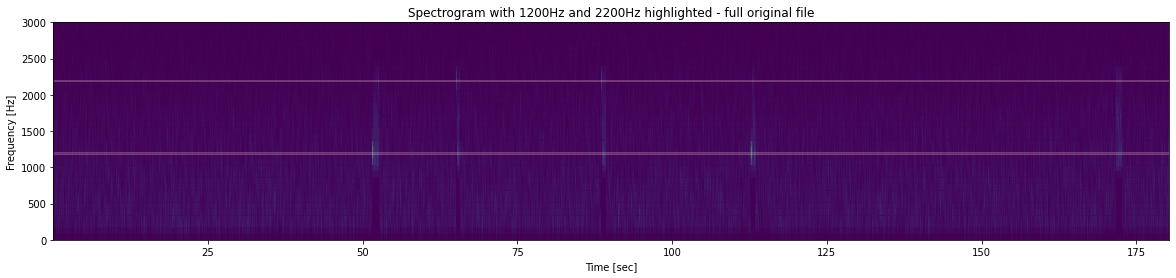

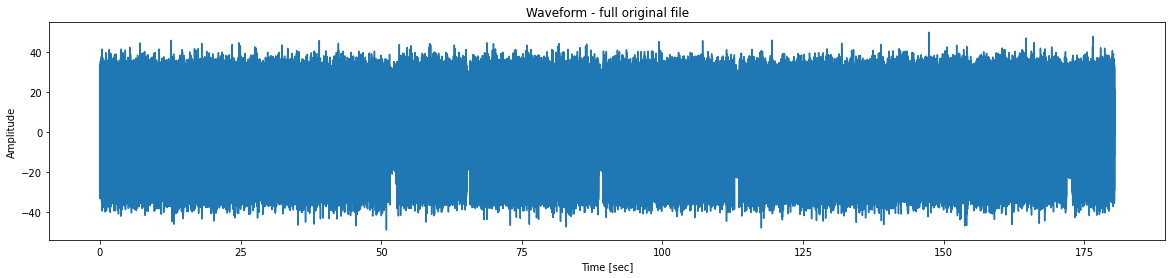

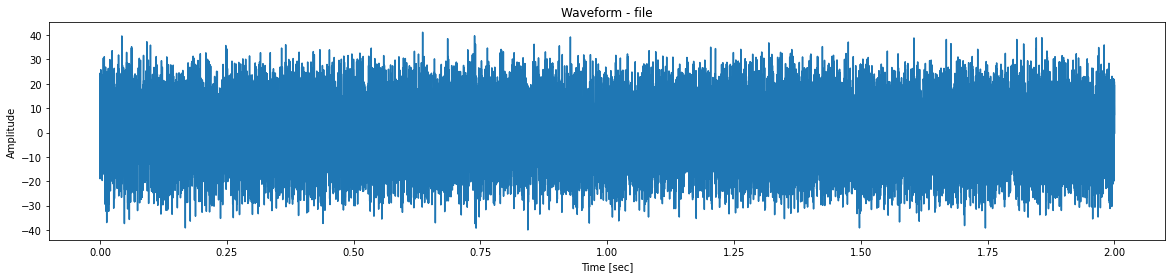

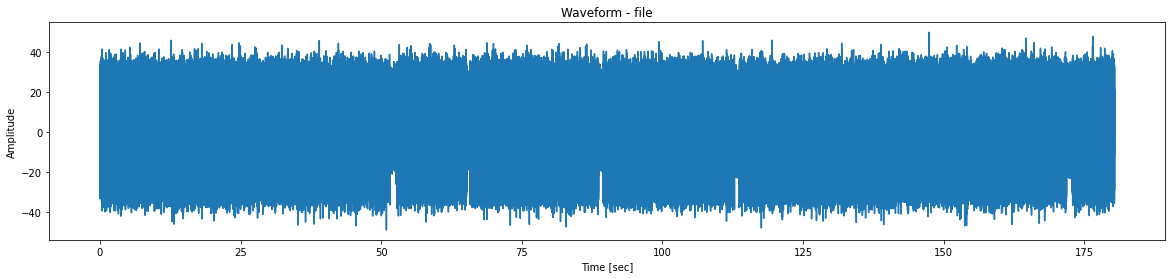

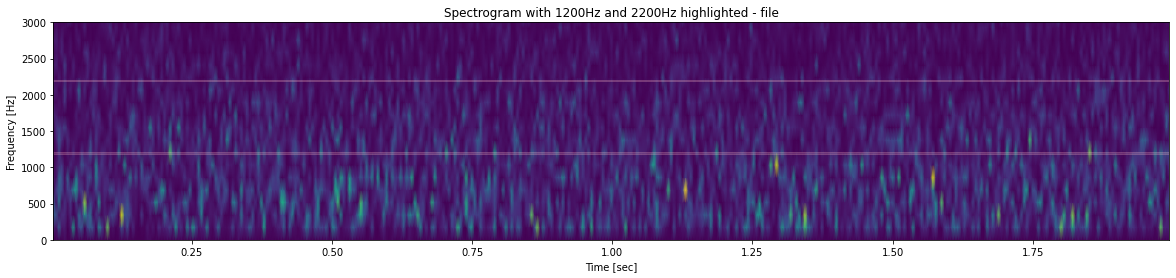

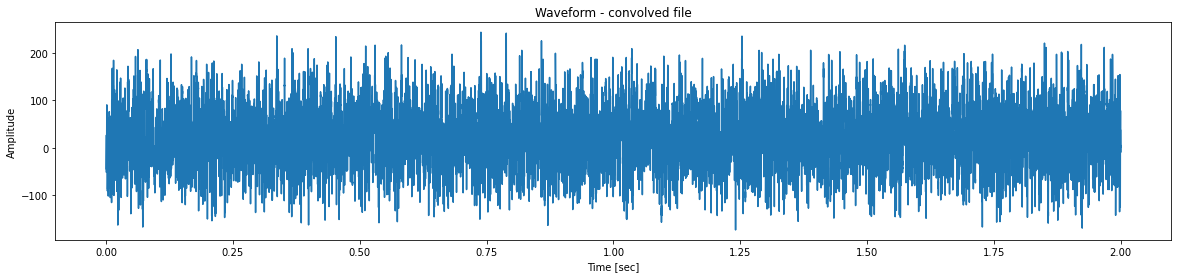

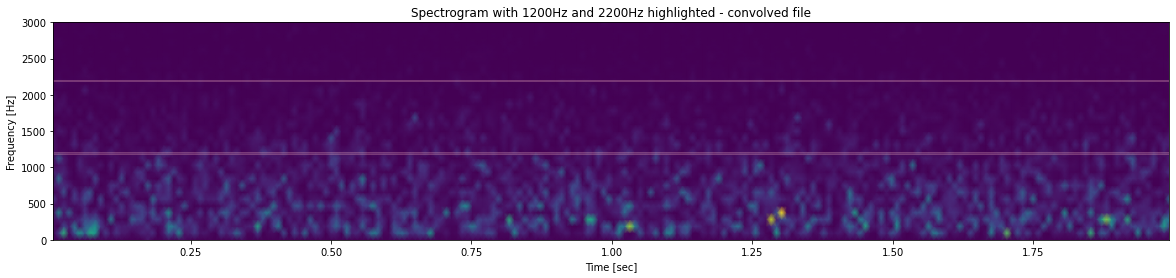

In [5]:
file_sample_rate, file = load_asset('aprs_audacity_3_long.wav')
file = remove_dc_bias(rescale_amplitude(file))

start_second = 1
end_second = 3

show_spectrogram(file, file_sample_rate, 'full original file')
show_waveform(file, file_sample_rate, 'full original file')

show_waveform(file[int(file_sample_rate*start_second):int(file_sample_rate*end_second)], file_sample_rate, 'file')
show_waveform(file, file_sample_rate, 'file')
show_spectrogram(file[int(file_sample_rate*start_second):int(file_sample_rate*end_second)], file_sample_rate, 'file')

new_sample_rate = 24000

resampled_file = resample_file(file, file_sample_rate, new_sample_rate)
# show_spectrogram(resampled_file[int(new_sample_rate*start_second):int(new_sample_rate*end_second)], new_sample_rate, 'resampled file')

def convolve_over_file(file):
    t20 = np.array([ x/20 for x in range(-10,10) ]).astype(np.longdouble)
    mf1200 = np.exp(1j*2*pi*t20*1.0)
    mf2200 = np.exp(1j*2*pi*t20*1.8)

    d12 = np.convolve(file, mf1200,'same')
    d22 = np.convolve(file, mf2200,'same')

    
#     return abs(d22)# + abs(d22)
    return abs(d12) - abs(d22)

convolved = convolve_over_file(resampled_file)
show_waveform(convolved[int(new_sample_rate*start_second):int(new_sample_rate*end_second)], new_sample_rate, 'convolved file')
show_spectrogram(convolved[int(new_sample_rate*start_second):int(new_sample_rate*end_second)], new_sample_rate, 'convolved file')

# filtered = apply_bandpass_to_file(resampled_file, new_sample_rate)

save_wav(resampled_file, new_sample_rate, '/tmp/resampled.wav')
save_wav(convolved, new_sample_rate, '/tmp/convolved.wav')
# save_wav(filtered, new_sample_rate, '/tmp/filtered.wav')

# convolved = convolve_over_file(filtered)
# show_waveform(convolved[int(new_sample_rate*start_second):int(new_sample_rate*end_second)])
# show_spectrogram(convolved[int(new_sample_rate*start_second):int(new_sample_rate*end_second)], new_sample_rate)

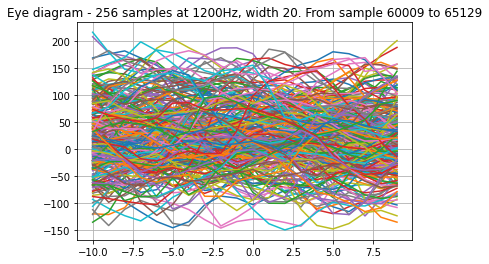

In [6]:
def create_eye_diagram(file, fs, start, offset, freq=1200):
    n_samples = 256
    width = int(fs/freq)
    half_width = int(width/2)
    
    n1 = start + offset
    n2 = n1 + width * n_samples

    eyed = np.reshape(file[n1-half_width:n2-half_width], (width, n_samples), 'F')

    fig, ax = plt.subplots()
    ax.plot(range(-half_width, half_width), eyed)
    ax.set(title=f'Eye diagram - {n_samples} samples at {freq}Hz, width {width}. From sample {n1} to {n2}')
    ax.grid()
    
create_eye_diagram(convolved, new_sample_rate, int(new_sample_rate*(start_second+1.5)), 9)
# create_eye_diagram(filtered, new_sample_rate, int(new_sample_rate*(start_second+1.5)), 9)

# fig, ax = plt.subplots()
# ax.plot(convolved[int(new_sample_rate*(start_second+1.5)):int(new_sample_rate*(start_second+1.5))+1500])
# ax.set(title='Eye diagram')
# ax.grid()
# fig.set_figwidth(20)

# show_spectrogram(resampled_file[int(new_sample_rate*(start_second+1.5)):int(new_sample_rate*end_second)], new_sample_rate)


## TODO

* Find a good way to isolate packets
* Find a good way to phase-sync packets

bucket length: 0.2s, 8820 per bucket, overlap: 17640
bucket length: 0.2s, 4800 per bucket, overlap: 9600


[1238400, 1564800, 2126400, 2707200, 3196800, 3624000, 4123200, 4137600]

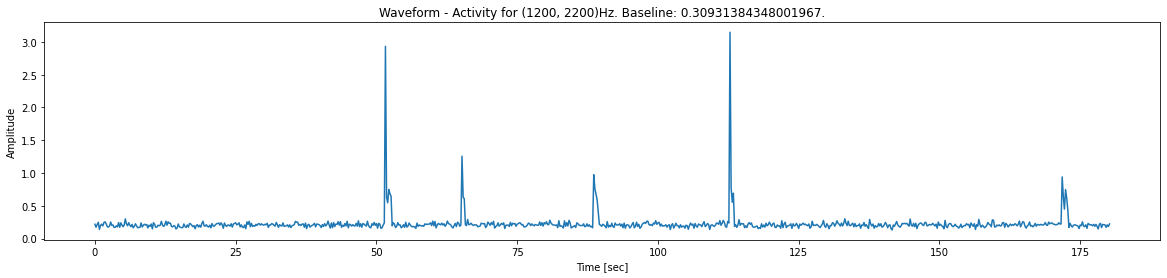

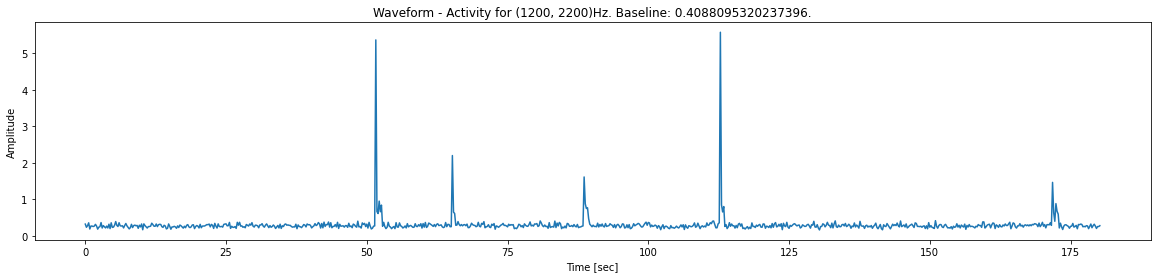

In [149]:
processed_file = resample_file(remove_dc_bias(rescale_amplitude(file)), file_sample_rate, new_sample_rate)
convolved_file = convolve_over_file(processed_file)

find_activity(file, file_sample_rate)
find_activity(processed_file, new_sample_rate)

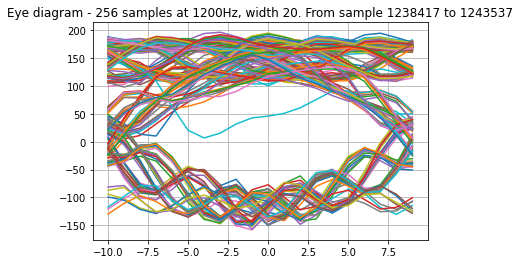

In [21]:
create_eye_diagram(
    blah,
    new_sample_rate,
    offset=17,
    start=round((2275560)*(new_sample_rate/file_sample_rate))
)

In [107]:
start = round((2275560)*(new_sample_rate/file_sample_rate))
end = round(2351780*(new_sample_rate/file_sample_rate))

In [108]:
def find_best_offset(file, start, fs, freq=1200):
    width = int(new_sample_rate/freq)
    n = 256

    # Return the index where the standard deviation is the biggest
    stdevs = [ stdev(file[start + offset:start + offset + (width*n):20]) for offset in range(0, width) ]
    return stdevs.index(max(stdevs))

In [109]:
offset = find_best_offset(blah, start, new_sample_rate)

In [110]:
bits = blah[start+offset:end+offset:20] > 0

In [111]:
db = nrzi_decode(bits)

Frames start at [2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 162, 170, 178, 186, 194, 202, 1423, 1880]
Frames end at   [10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 162, 170, 178, 186, 194, 202, 210, 1431, 1888]


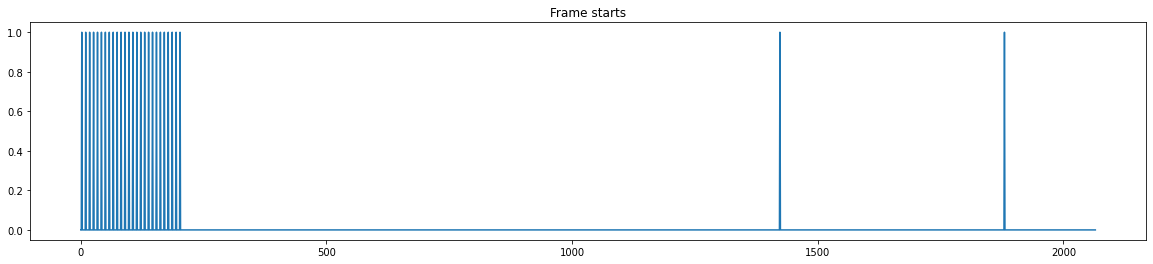

Packet starts at 210, ends at 1423
Length before destuffing: 1213
Bit de-stuff: removing 0 at position 282
Bit de-stuff: removing 0 at position 297
Bit de-stuff: removing 0 at position 303
Bit de-stuff: removing 0 at position 382
Bit de-stuff: removing 0 at position 749
Length after destuffing: 1208


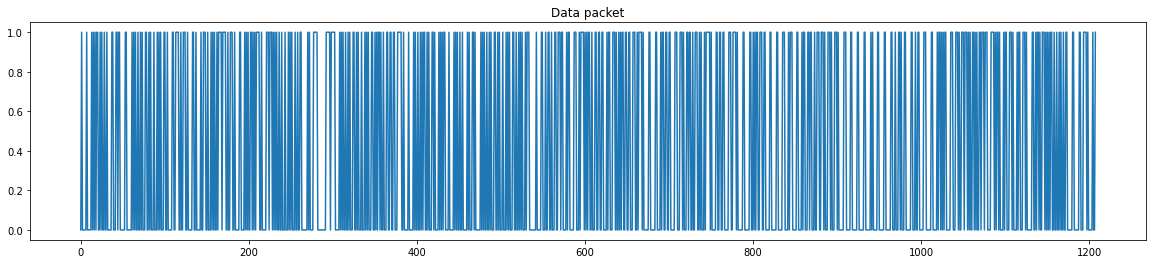

In [130]:
frame_starts = [ sum([not(s0), s1, s2, s3, s4, s5, s6, not(s7)]) for s0,s1,s2,s3,s4,s5,s6,s7 in zip(db, db[1:], db[2:], db[3:], db[4:], db[5:], db[6:], db[7:])]

frame_start_indices = [ idx for idx, x in enumerate(frame_starts) if x == 8 ]

print(f'Frames start at {frame_start_indices}')

print(f'Frames end at   {list(map(lambda x: x + 8, frame_start_indices))}')

fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(list(map(lambda x: x == 8, frame_starts)))
ax.set(title='Frame starts')
plt.show() 

[packet_start, packet_end] = [ (curr + 8, next) for curr, next in zip(frame_start_indices, frame_start_indices[1:]) if curr != next - 8 ][0]

print(f'Packet starts at {packet_start}, ends at {packet_end}')
# packet_start = 210
# packet_end = 1423

packet = np.array(db[packet_start:packet_end]).astype(int)
print(f'Length before destuffing: {len(packet)}')
packet = bit_destuff(packet)
print(f'Length after destuffing: {len(packet)}')

fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(packet)
ax.set(title='Data packet')
plt.show() 

In [131]:
def parse_packet(pack):
    # Digipeater addresses are 7 characters long
    # A '1' in the left-most position of the byte (LBS) signifies the digipeater list is over
    number_of_digipeaters_addresses = len(list((takewhile(lambda offset: chunk(packet, 8)[14::7][offset][0] == 0, range(0,9)))))
    
    return {
        "destination": parse_address(pack[0:7]),
        "source": parse_address(pack[7:14]),
        "digipeaters": list(map(lambda digipeater_offset: parse_address(pack[14+digipeater_offset*7:14+digipeater_offset*7+7]), range(0, number_of_digipeaters_addresses))),
        "control_field": pack[14+number_of_digipeaters_addresses*7],
        "protocol_id": pack[15+number_of_digipeaters_addresses*7],
        "information": ''.join(list(map(lambda b: byte_to_char(b), pack[16+number_of_digipeaters_addresses*7:]))[:-2]),
        "frame_check_sequence": pack[-2:]
    }

parse_packet(chunk(packet, 8))


{'destination': {'callsign': 'APMI06',
  'ssid': 0,
  'reserved_bits': array([1, 1]),
  'command_response': False},
 'source': {'callsign': 'PI1ETL',
  'ssid': 0,
  'reserved_bits': array([1, 1]),
  'command_response': False},
 'digipeaters': [{'callsign': 'ON0ANT',
   'ssid': 10,
   'reserved_bits': array([1, 1]),
   'command_response': True},
  {'callsign': 'ON0TVO',
   'ssid': 0,
   'reserved_bits': array([1, 1]),
   'command_response': True},
  {'callsign': 'WIDE2',
   'ssid': 0,
   'reserved_bits': array([1, 1]),
   'command_response': True}],
 'control_field': array([1, 1, 0, 0, 0, 0, 0, 0]),
 'protocol_id': array([0, 0, 0, 0, 1, 1, 1, 1]),
 'information': '}PI1ETL-13>APRS,TCPIP,PI1ETL*:@021748z5134.53N/00438.69E_038/005g008t046r...p000P000b10280h58.weewx-4.4.0-WMR200',
 'frame_check_sequence': [array([0, 1, 1, 1, 1, 0, 1, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 1])]}